<a href="https://colab.research.google.com/github/cielo112/Sentiment_Analysis_and_Clustering_Using_RoBERTa/blob/main/Sentiment_Analysis_and_Clustering_for_Women's_Clothing_E_commerce_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Description

In the era of digital commerce, customer reviews play a vital role in decision-making processes for online shoppers. This project aims to analyze women's clothing e-commerce reviews using sentiment analysis techniques and apply clustering algorithms to gain deeper insights into the products being reviewed. By leveraging the power of machine learning, we can extract valuable information and patterns from the vast amount of textual data available, helping businesses make informed decisions regarding product offerings, marketing strategies, and customer satisfaction.

**Objectives:**

* Perform sentiment analysis: Utilize natural language processing (NLP) techniques to extract sentiment polarity (positive, negative, or neutral) from women's clothing reviews. This analysis will provide an overall understanding of customers' opinions and attitudes towards the products.

* Apply clustering algorithms: Employ unsupervised learning algorithms, such as k-means, to group customers based on products purchased and the sentiments expressed in their reviews. Clustering will help identify subgroups that share similar characteristics or elicit similar customer responses.

* Gain insights into customer preferences: By analyzing the clustered groups, uncover common themes, characteristics, or attributes that influence customers' opinions and purchasing decisions. Identify the most influential factors that drive positive or negative sentiments, enabling businesses to tailor their strategies and improve product offerings accordingly.

**Table of Contents**

1. Initial Look at the Dataset
2. Sentiment Analysis using RoBERTa
3. Data Preprocessing
4. Dimensionality Reduction
5. KMeans Clustering
6. Exploratory Analysis
7. Conclusion


#Initial Look at the Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Datasets/Womens-Clothing-E-Commerce-Reviews.csv')

In [ ]:
df.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [ ]:
df.tail(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses
23485,23485,1104,52,Please make more like this one!,This dress in a lovely platinum is feminine an...,5,1,22,General Petite,Dresses,Dresses


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [ ]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [ ]:
df = df.dropna()

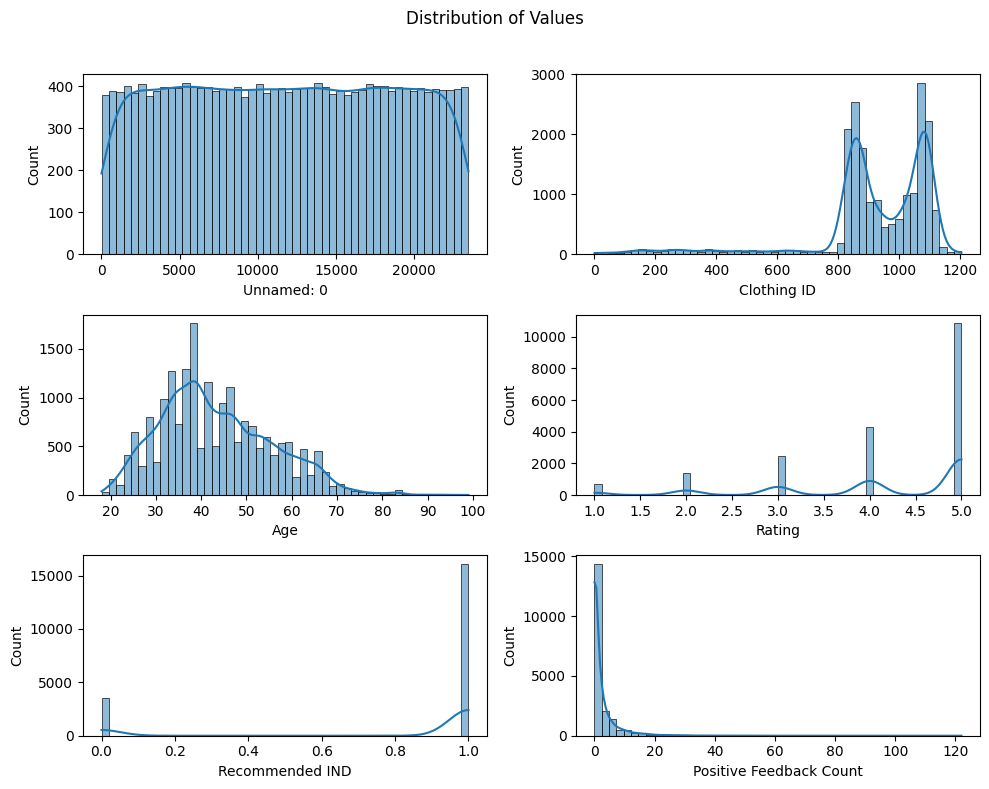

In [ ]:
fig, axs = plt.subplots(figsize=(10,8), nrows= 3, ncols = 2)
for i, col in zip(range(1,7), df.select_dtypes(['int', 'float']).columns):
  plt.subplot(3,2,i)
  sns.histplot(data=df, x=df[col], bins=50 , kde= True)
plt.suptitle('Distribution of Values')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()


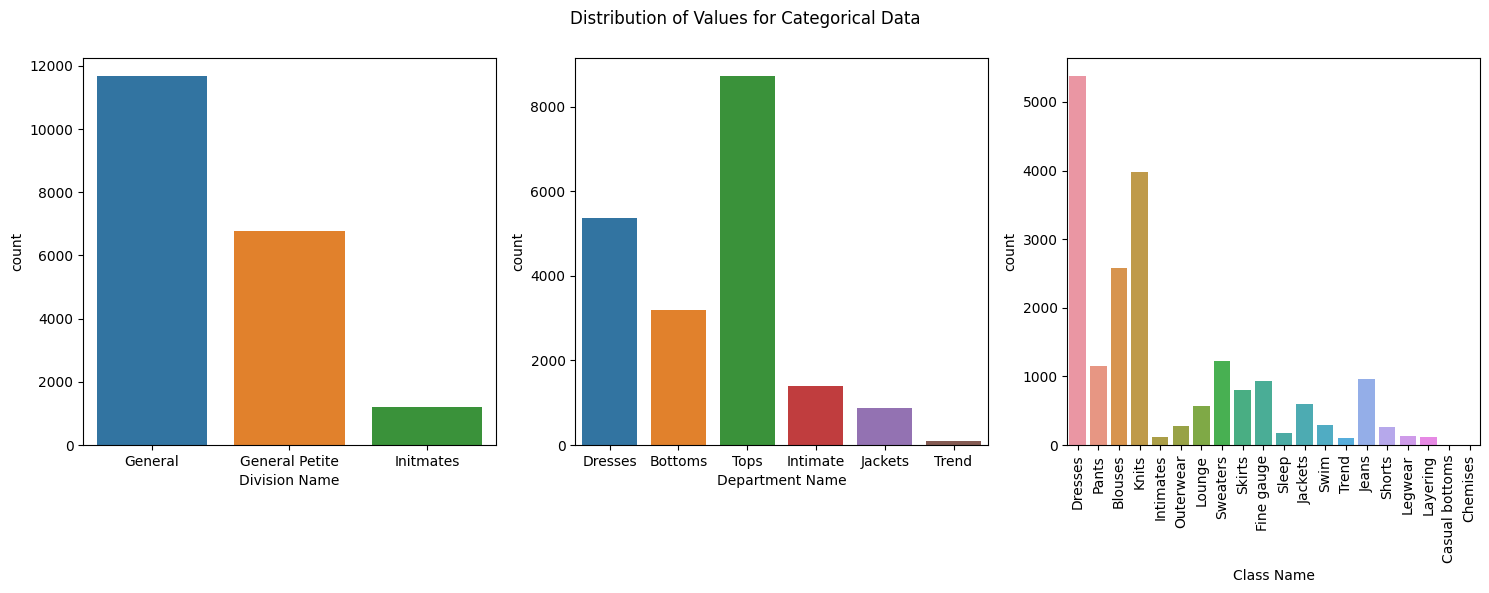

In [ ]:
fig, axs = plt.subplots(figsize=(15,6), nrows=1, ncols=3)
for i, col in zip(range(1,4), ['Division Name','Department Name','Class Name']):
  plt.subplot(1,3,i)
  sns.countplot(data=df, x=df[col])
  if col == 'Class Name':
    plt.xticks(rotation= 90)
plt.suptitle('Distribution of Values for Categorical Data')
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

#Sentiment Analysis using RoBERTa

Sentiment analysis, also known as opinion mining, is a branch of natural language processing (NLP) that involves the use of computational techniques to determine and categorize the sentiment or subjective opinion expressed in a piece of text. The goal of sentiment analysis is to understand the emotional tone behind a given text, whether it's positive, negative, or neutral.

In this project we will be using a pretrained model called RoBERTa for sentiment analysis. RoBERTa stands for "A Robustly Optimized BERT Pretraining Approach." It is a language model architecture that builds upon the popular BERT (Bidirectional Encoder Representations from Transformers) model. RoBERTa was introduced by researchers at Facebook AI in 2019.

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def roberta_polarity_scores(text):
  encoded = tokenizer(text, return_tensors='pt')
  output = model(**encoded)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'negative' : scores[0],
      'neutral' : scores[1],
      'postive' : scores[2]
  }
  return scores_dict

In [ ]:
tqdm.pandas()
scores_dict = tqdm(df['Review Text'].progress_apply(roberta_polarity_scores), total=len(df))

  0%|          | 0/19662 [00:00<?, ?it/s]

  0%|          | 0/19662 [00:00<?, ?it/s]

In [ ]:
roberta_scores = pd.DataFrame(scores_dict)
roberta_scores = roberta_scores.reset_index().rename(columns={'index': 'Unnamed: 0'})
df = roberta_scores.merge(df, how='left')

In [ ]:
df.head()

,Unnamed: 0,negative,neutral,postive,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,0.366803,0.380140,0.253057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.002247,0.004622,0.993131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.001239,0.006733,0.992028,1077.0,60.0,Some major design flaws,I had such high hopes for this dress and reall...,3.0,0.0,0.0,General,Dresses,Dresses
3,3,0.170491,0.283566,0.545943,1049.0,50.0,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,1.0,0.0,General Petite,Bottoms,Pants
4,4,0.005863,0.072109,0.922028,847.0,47.0,Flattering shirt,This shirt is very flattering to all due to th...,5.0,1.0,6.0,General,Tops,Blouses


In [ ]:
df = df.dropna()

#Data Preprocessing

Before applying clustering algorithms in machine learning, it is essential to perform preprocessing steps to prepare the data for analysis. Preprocessing helps to enhance the quality of the data and improve the performance and accuracy of clustering algorithms. Here are some of the preprocessing steps we are going to employ in this dataset:

1. Encoding Categorical Variables: Clustering algorithms typically work with numerical data, so categorical variables need to be encoded. One-hot encoding or label encoding can be used depending on the nature of the categorical variables.

2. Feature Scaling: To ensure that all features contribute equally to the clustering process, it is important to scale the data. Common scaling techniques include standardization (mean = 0, standard deviation = 1) or normalization (scaling values between 0 and 1).

In [ ]:
cat_cols = [col for col in df.select_dtypes('object').columns]
num_cols = [col for col in df.select_dtypes(['int', 'float']).columns]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

In [ ]:
df_trans = pipeline.fit_transform(df)

# Dimensionality Reduction

Dimensionality Reduction is the process of reducing the number of features or variables in a dataset. The greater the number of variables present the more computationally exhaustive the model building becomes. This is why this is typically done as part the preprocessing steps before feeding the data into a Machine Learning algorithm. Apart from this, the reduction in dimension can also allow us to better visualize how the variables are related, which may also help in clustering the data.

In this section, we will be using Truncated SVD in particular to perform the dimensionality reduction instead of the usual Principal Component Analysis. The reason for this is because we have transformed our dataset by performing One Hot Encoding. The One Hot Encoding method created a sparse matrix that is not compatible with PCA, for this kind of data the Truncated SVD is much more suited.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3)
df_reduced = svd.fit_transform(df_trans)
df_reduced = pd.DataFrame(df_reduced, columns=['col1', 'col2', 'col3'])

df_reduced.describe()


,col1,col2,col3
count,16462.000000,16462.000000,16462.000000
mean,-0.007022,0.033490,0.392247
std,1.572872,1.343891,1.070316
min,-1.183734,-1.301922,-4.190515
25%,-1.057570,-0.834357,-0.053785
50%,-0.892524,-0.692241,0.352425
75%,0.509667,0.006556,1.311478
max,4.203486,5.349520,4.857767


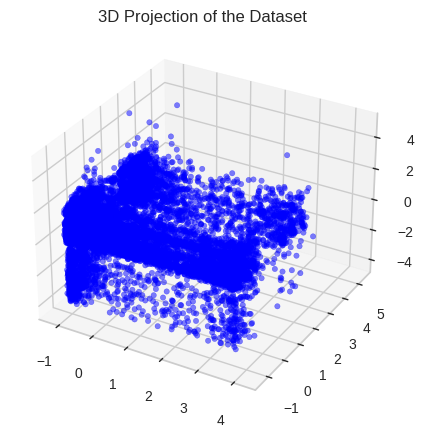

In [ ]:
x = df_reduced['col1']
y = df_reduced['col2']
z = df_reduced['col3']

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection='3d')

ax.scatter3D(x, y, z, color = 'blue', alpha = 0.5, s= 15)
plt.title('3D Projection of the Dataset')
plt.show()

#Clustering Using KMeans

K-means is an unsupervised learning algorithm that partitions the data into k clusters based on their similarity. In this case, the sentiment scores along with other relevant features of the clothing items (division, department, class) can be used as input to the k-means algorithm.

The goal is to group similar clothing items together based on both their features and sentiments. This allows for the identification of clusters that represent distinct segments of customers with similar sentiments and preferences.

**Number of Clusters**

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

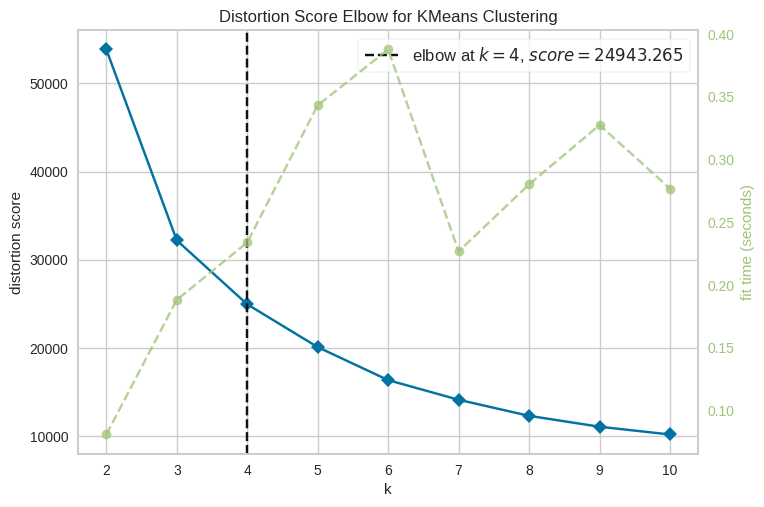

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(df_reduced)
elbow.show()

**Implementing KMeans Clustering**

In [ ]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(df_reduced)

In [ ]:
df_reduced['Clusters'] = y_pred

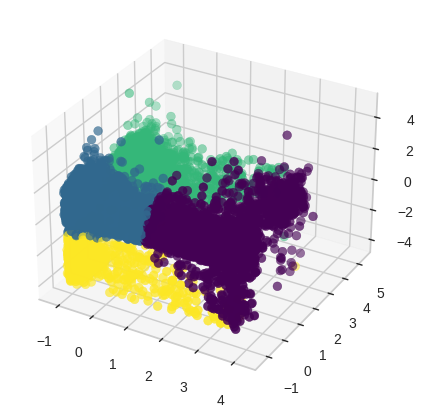

In [ ]:
fig, axs = plt.subplots(figsize=(10,5))
axs = plt.subplot(111, projection = '3d', label='bla')
axs.scatter(x ,y, z, s=40, c=df_reduced['Clusters'], cmap='viridis')
plt.show('Clusters in the 3D Projection')
plt.show()

# Exploratory Analysis with the Clusters

Now that we have clustered our dataset, let us try to gain more insights regarding specific customer preferences and product characteristics by exploring the following questions:

* How are the clusters distributed across the different age ranges? Are some clusters comprised of older or younger customers?
* What are the preferred products by the different clusters based on the number of purchases made?
* Is there a difference in the way each cluster rate the products? Are there clusters who are more likely to give a negative review?
* Which specific product/products has the highest rating?
* Is there a difference in the likelihood of giving positive sentiment across the different clusters? If yes, then which one is most likely to give positive sentiment and which one is least likely?
* Which product, if any, is most likely to receive positive sentiment? How about negative sentiment?

In [ ]:
df['Cluster'] = y_pred
df.head(3)

,Unnamed: 0,negative,neutral,postive,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Cluster
2,2,0.001239,0.006733,0.992028,1077.0,60.0,Some major design flaws,I had such high hopes for this dress and reall...,3.0,0.0,0.0,General,Dresses,Dresses,2
3,3,0.170491,0.283566,0.545943,1049.0,50.0,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5.0,1.0,0.0,General Petite,Bottoms,Pants,0
4,4,0.005863,0.072109,0.922028,847.0,47.0,Flattering shirt,This shirt is very flattering to all due to th...,5.0,1.0,6.0,General,Tops,Blouses,1


**Distribution of Clusters**

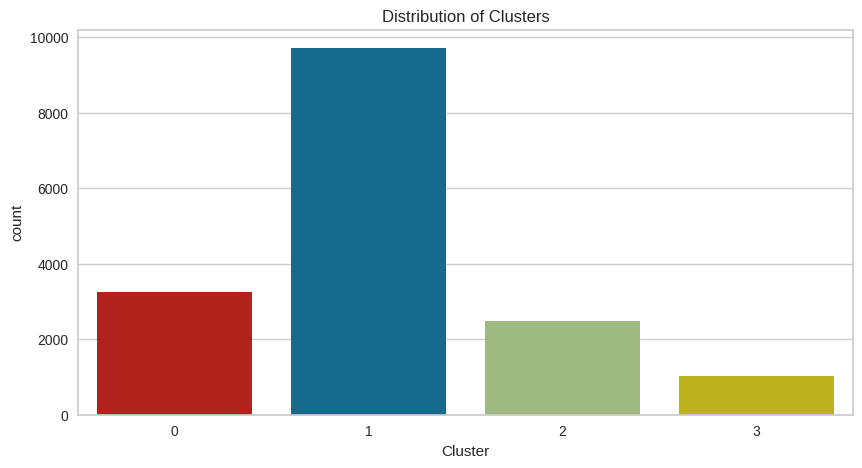

In [ ]:
fig, axs = plt.subplots(figsize=(10,5))
sns.countplot(data=df, x='Cluster', palette=['r', 'b','g', 'y'])
plt.title('Distribution of Clusters')
plt.show()


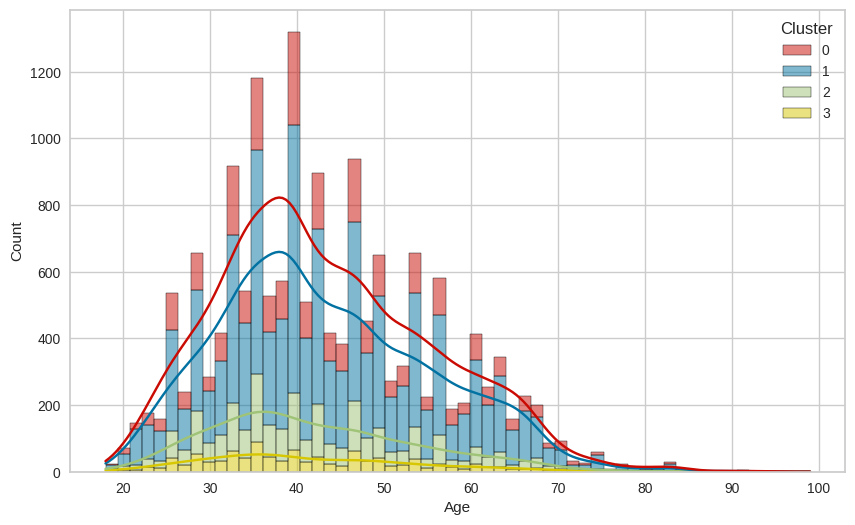

In [ ]:
fig, axs = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='Age', hue='Cluster', palette=['r', 'b','g', 'y']
             , kde= True, multiple='stack')
plt.title('Distribution of Age in for Dirffere')
plt.show()

Insights from the Distribution Graphs:

* Majority of the customers who gave a review in the ecommerce website belong to cluster 1 with the least coming from cluster 3. This could mean that marketing strategies must be directed to improve the reach to people that belong to cluster 3.

* There is slight but noticeable difference in the distribution of the clusters across the age groups. Cluster 0 and cluster 1 are skwewed more towards the right while cluster 2 and cluster 3 are leaning more to the left. This means that clusters 0 and 1 are on average older than clusters 2 and 3. This has to be taken into account for the different garments that will be recommend to each cluster for a more targeted approach.

**Product Preference of Each Cluster**

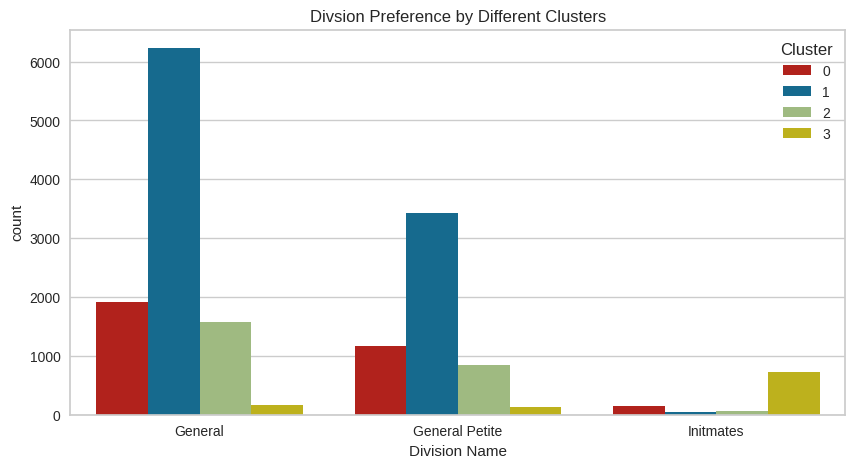

In [ ]:
fig, axs = plt.subplots(figsize=(10,5))
sns.countplot(data=df, x='Division Name', hue='Cluster', palette=['r', 'b','g', 'y'])
plt.title('Divsion Preference by Different Clusters')
plt.show()

Insights from the graph:

* All clusters with the exception of cluster 3, buy general garments the most and intimate garments the least. For cluster 3 this is reversed with them primarily buying intimate garments instead. This indicates that cluster 3 is a unique subgroup of customers with a defined product preference.

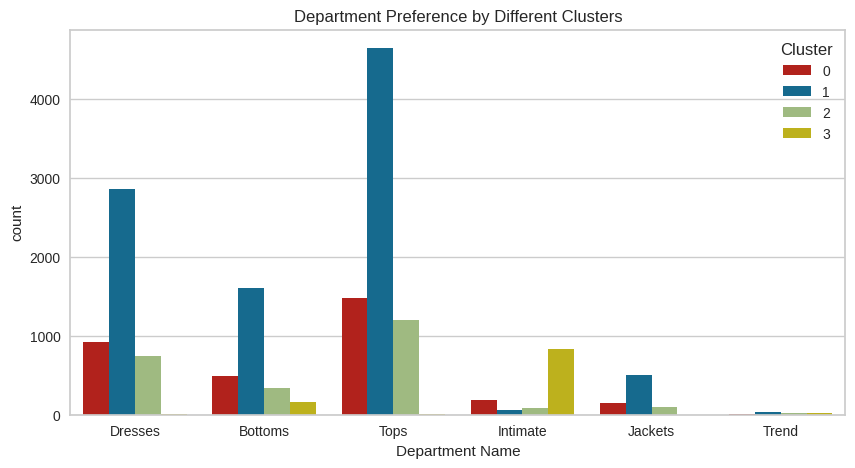

In [ ]:
fig, axs = plt.subplots(figsize=(10,5))
sns.countplot(data=df, x='Department Name', hue='Cluster', palette=['r', 'b','g', 'y'])
plt.title('Department Preference by Different Clusters')
plt.show()

Insights from the graph:

* The best selling department of garments are the tops, with cluster 1 buying them the most. The least preferred garment though are the ones who are trendy with all clusters buying them the least. This information could be used to make decision on stocking priority and product placement in the website.

* It is again seen that intimate garments are the most bought garments by cluster 3.

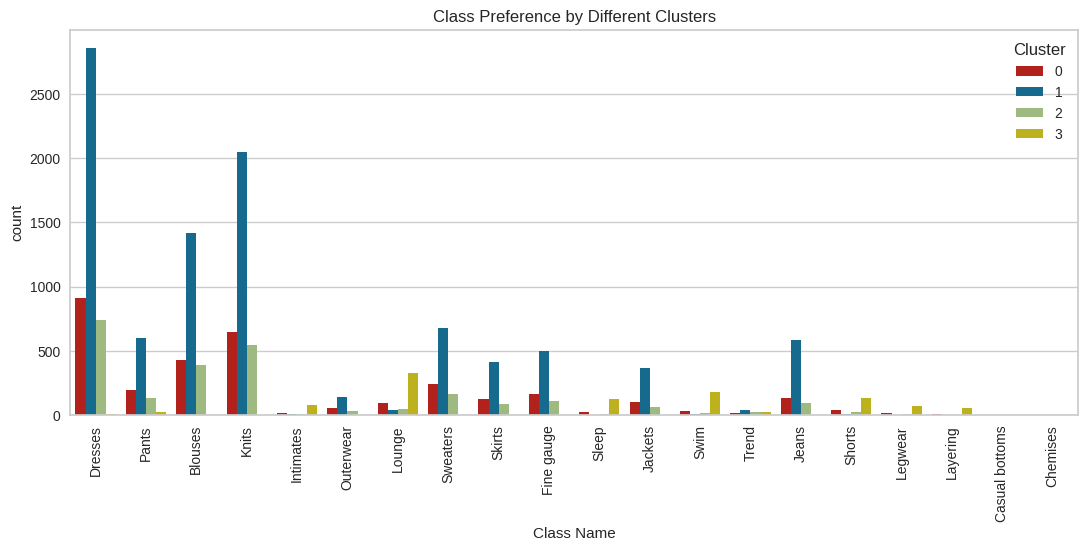

In [ ]:
fig, axs = plt.subplots(figsize=(13,5))
sns.countplot(data=df, x='Class Name', hue='Cluster', palette=['r', 'b','g', 'y'])
plt.xticks(rotation=90)
plt.title('Class Preference by Different Clusters')
plt.show()

**Rating Analysis**

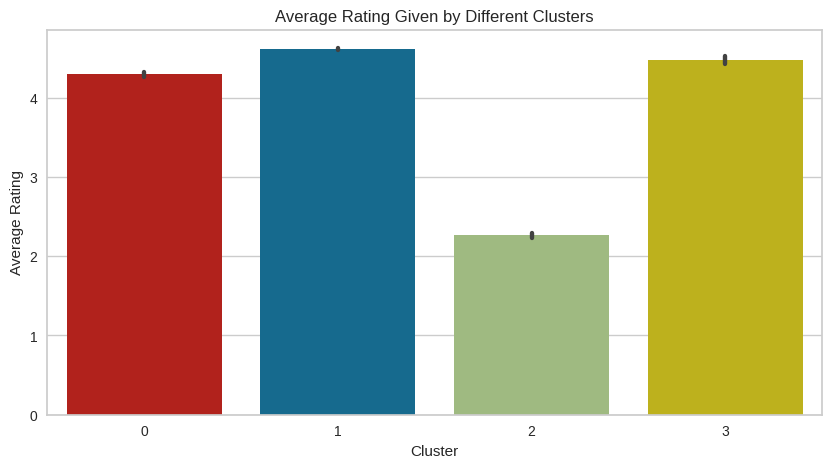

In [ ]:
fig, axs = plt.subplots(figsize=(10,5))
sns.barplot(data=df, x='Cluster', y='Rating', palette=['r', 'b','g', 'y'])
plt.ylabel('Average Rating')
plt.title('Average Rating Given by Different Clusters')
plt.show()

Insights from the graph:

* On average, customers in cluster 2 give the lowest rating while customers in cluster 1 give the highest. From this data, together with the purchasing preference of cluster 2, a marketing scheme can be deviced to address the negative ratings made by cluster.

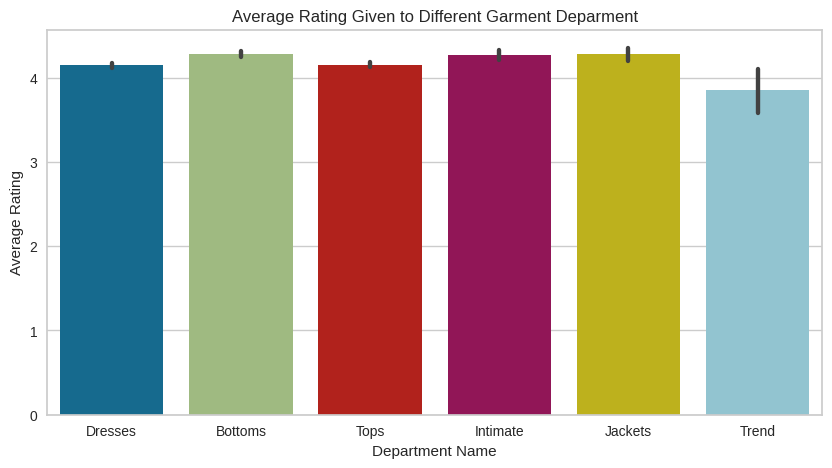

In [ ]:
fig, axs = plt.subplots(figsize=(10,5))
sns.barplot(data=df, x='Department Name', y='Rating')
plt.ylabel('Average Rating')
plt.title('Average Rating Given to Different Garment Deparment')
plt.show()

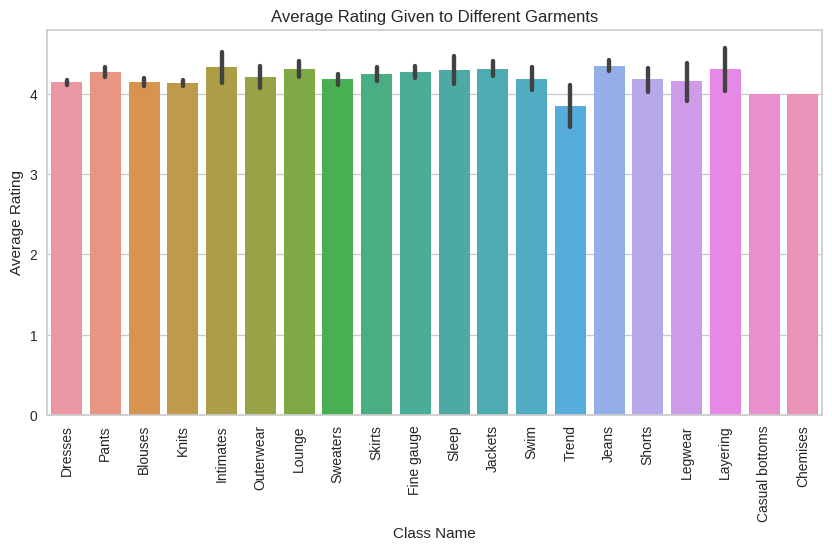

In [ ]:
fig, axs = plt.subplots(figsize=(10,5))
sns.barplot(data=df, x='Class Name', y='Rating')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.title('Average Rating Given to Different Garments')
plt.show()

Insights from the graphs:

* The department that typically receives a low rating are the one who follows the trend.It has on average a rating of below 4 with the rest of the deparment being above this. It has to be noted tho that the variation  in the rating for the Trend Department is also the highest amongst the departments which indicates that there is a significant polarity in opinions among the customers who buy garments from this department.

**Sentiment Analysis**

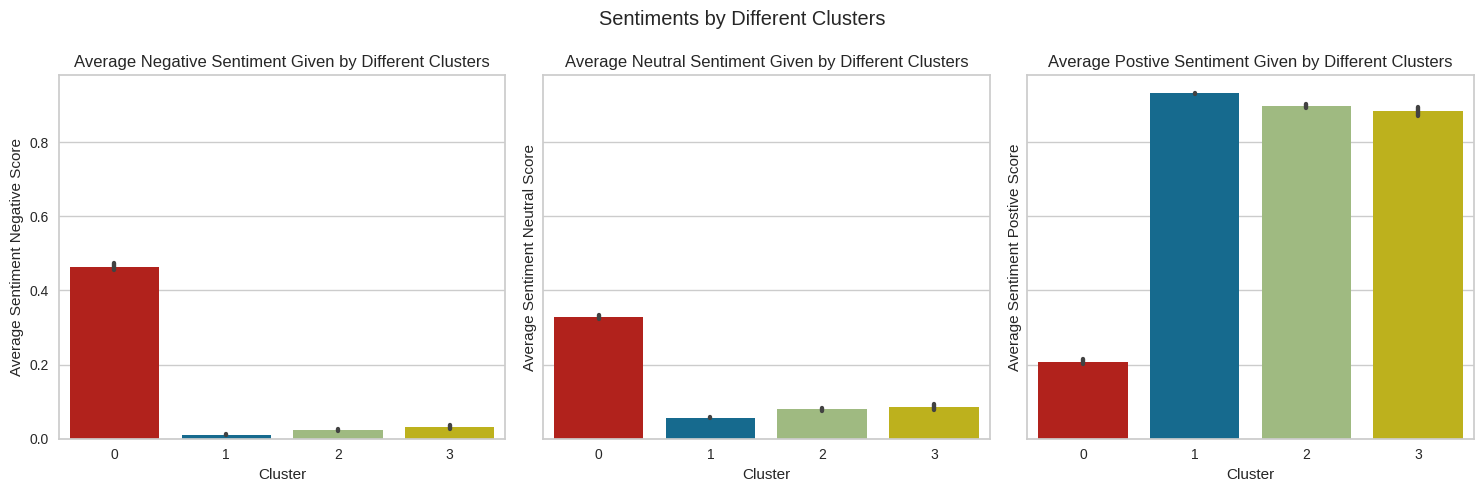

In [ ]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=3, sharey=True)
for i, col in zip(range(1,4), ['negative', 'neutral', 'postive']):
  plt.subplot(1,3,i)
  sns.barplot(data=df, x='Cluster', y=df[col], palette=['r', 'b','g', 'y'])
  plt.ylabel('Average Sentiment '+ col.capitalize() + ' Score')
  plt.title('Average '+ col.capitalize() + ' Sentiment Given by Different Clusters')
plt.suptitle('Sentiments by Different Clusters')
fig.tight_layout()
plt.show()

Insights from the graph:

* The cluster with the most negative sentiment is cluster 0 which is an intersting result because in the analysis of the ratings given, it was cluster 2 who on average gave the lowest ratings. This indicates that while cluster 0 does not give low ratings, they express negative sentiments regarding the products that they purchase.

* Cluster 1 gives the most positive sentiment which also coincides with the ratings that it gives since it also gives the highest ratings on average.

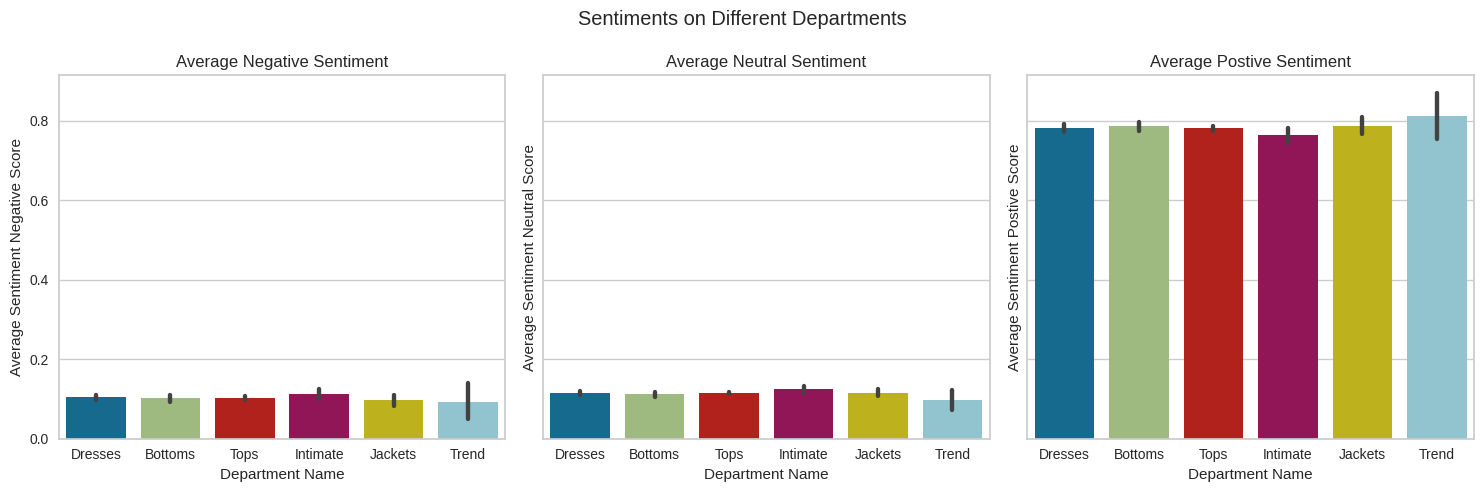

In [ ]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=3, sharey=True)
for i, col in zip(range(1,4), ['negative', 'neutral', 'postive']):
  plt.subplot(1,3,i)
  sns.barplot(data=df, x='Department Name', y=df[col])
  plt.ylabel('Average Sentiment '+ col.capitalize() + ' Score')
  plt.title('Average '+ col.capitalize() + ' Sentiment')
plt.suptitle('Sentiments on Different Departments')
fig.tight_layout()
plt.show()

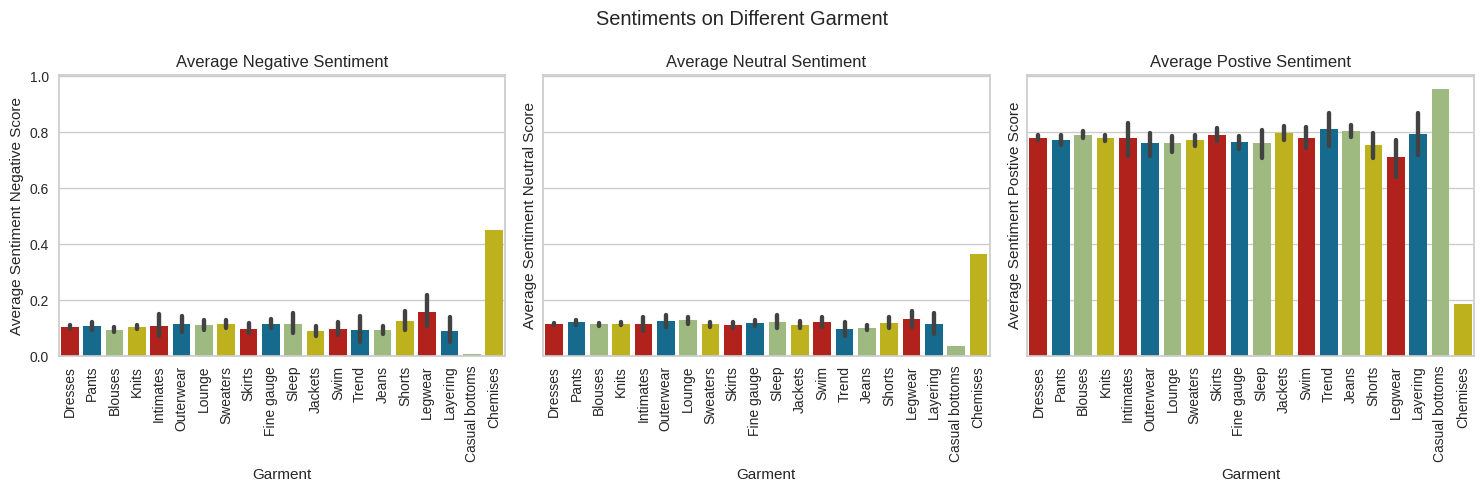

In [ ]:
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=3, sharey=True)
for i, col in zip(range(1,4), ['negative', 'neutral', 'postive']):
  plt.subplot(1,3,i)
  sns.barplot(data=df, x='Class Name', y=df[col], palette=['r', 'b','g', 'y'])
  plt.ylabel('Average Sentiment '+ col.capitalize() + ' Score')
  plt.xticks(rotation=90)
  plt.xlabel('Garment')
  plt.title('Average '+ col.capitalize() + ' Sentiment')
plt.suptitle('Sentiments on Different Garment')
fig.tight_layout()
plt.show()

Insights from the graphs:

* The sentimet scores of most of the products are withuin the same range with few exceptions such as Leg wear, Casual Bottoms, and Chemises. The Chemises received the most negative sentiments while the Casual Bottoms received the most postive sentiments.

# Conclusion

In conclusion, this project successfully utilized RoBERTa, a robust language model, to determine sentiment scores for a given dataset. By leveraging RoBERTa's powerful contextual understanding, the sentiment analysis task was performed effectively, allowing for a comprehensive assessment of the sentiment associated with each data point.

Furthermore, the project employed clustering techniques on the sentiment scores to conduct exploratory data analysis. By reducing the dimensionality of the dataset and grouping similar sentiment patterns together, valuable insights and patterns were extracted from the data. The use of clustering helped identify distinct sentiment clusters, enabling a deeper understanding of the underlying sentiment distribution within the dataset.